# Deel Home Task
### Tania LaGambina

This notebook outlines my Exploratory Data Analysis for the Data Science Challenge. The core code for the analysis is stored in separate code packages, which could be reused or incorporated into an analysis pipeline. Other code is included in this notebook that is largely exploratory, so I have kept that separate from the packages (for example a lot of visualisations!). 

In [1]:
!conda activate deel_task
!pip install -r requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn import pipeline
from pathlib import Path
import json
import calendar
from mappers import globepay_mappers
from helpers import outlier_analysis_helpers, clean_report_helpers, data_preparation_helpers
from analysis import logistic_regression_analysis, feature_importance_analysis, acceptance_rate_analysis


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.


  Using cached pandas-2.0.3-cp310-cp310-macosx_10_9_x86_64.whl (11.8 MB)
  Using cached numpy-1.24.4-cp310-cp310-macosx_10_9_x86_64.whl (19.8 MB)
  Using cached pydantic-2.8.2-py3-none-any.whl (423 kB)
ERROR: Ignored the following versions that require a different python version: 3.10.0.0 Requires-Python >=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, <3.5; 3.7.4.2 Requires-Python >=2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*, <3.5
ERROR: Could not find a version that satisfies the requirement typing~=3.10.0.0 (from versions: 3.5.0b1, 3.5.0, 3.5.0.1, 3.5.1.0, 3.5.2.2, 3.5.3.0, 3.6.1, 3.6.2, 3.6.4, 3.6.6, 3.7.4

In [2]:
deel_palette = {
    True: "#5838b7",
    False: "#fff0da"
}
sns.set_palette(sns.color_palette([deel_palette[True], deel_palette[False]]))

Reading in the data reports, preserving the different separated values of each. skipinitialspace also adds some preliminary data cleaning to whitespace.

In [3]:
THIS_FILE = Path.cwd()
data_path = THIS_FILE / "data"

globepay_acceptance_report_dataframe = pd.read_csv(
    data_path / "Globepay Acceptance Report - Globepay Acceptance Report..csv", 
    sep=";",
    skipinitialspace=True
)
globepay_chargeback_report_dataframe = pd.read_csv(
    data_path / "Globepay Chargeback Report - Globepay Chargeback Report..csv", 
    skipinitialspace=True
)
original_acceptance_report_length = len(globepay_acceptance_report_dataframe)
original_chargeback_report_length = len(globepay_chargeback_report_dataframe)

## Data Cleaning
General data cleaning of the raw date. Including whitespace removal, removal of nan values, dropping of duplicates and data validation. Given my initial observations of this dataset are that it is pretty clean and standardised, text cleaning is not needed. However if it was, this is the stage in which I would do it.

In [4]:
clean_report_helpers.whitespace_remover(globepay_chargeback_report_dataframe)
clean_report_helpers.whitespace_remover(globepay_acceptance_report_dataframe)

,external_ref,status,source,ref,date_time,state,cvv_provided,amount,country,currency,rates
0,nCyEIIGaP5QQ2Wqb-_Rt8,True,GLOBALPAY,evt_1ESgcCOV7fY1ChY1MkZizZt,2019-01-01T00:00:00.000Z,DECLINED,False,1020.46,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
1,ptNiI9B7NNpK7VsMZx6zZ,True,GLOBALPAY,evt_1EBMGCEjEtianKMJaZXOx1y,2019-01-01T04:48:00.000Z,ACCEPTED,False,1582.57,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
2,1GS5BDKBnauCt-3nHPs6x,True,GLOBALPAY,evt_1EOALu0AZqEhZBn9ub_nbcE,2019-01-01T09:36:00.000Z,DECLINED,False,1653.07,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
3,Y_oecYz8GjBDaxmMqkkLQ,True,GLOBALPAY,evt_1ESHsWyaSPqE1mrmJ2B6rvs,2019-01-01T14:24:00.000Z,ACCEPTED,False,2228.17,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
4,LlEs1TnKVa2xX6PH9Zsz0,True,GLOBALPAY,evt_1EjzPk13qLzmvDR_4hXuMMw,2019-01-01T19:12:00.000Z,ACCEPTED,False,2589.92,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
...,...,...,...,...,...,...,...,...,...,...,...
5425,mej1WI86fIPr4fZStA1wx,True,GLOBALPAY,evt_1EhM7CrZvfh_Aw8H-aP-Sgu,2019-06-30T00:00:00.000Z,ACCEPTED,False,178728.10,AE,USD,"{""CAD"":1.3804492977599183,""EUR"":0.701309191107..."
5426,bl5iBGuCq9zNpQDaCGWHP,True,GLOBALPAY,evt_1EuNMahC_lsgbRGMDHcuJdB,2019-06-30T04:48:00.000Z,DECLINED,False,179198.55,AE,USD,"{""CAD"":1.3804492977599183,""EUR"":0.701309191107..."
5427,RPAQwH-O6cBXjzWqS7O6D,True,GLOBALPAY,evt_1EcQnLsAtP8N1mlkTN1j-A1,2019-06-30T09:36:00.000Z,ACCEPTED,False,179388.92,AE,USD,"{""CAD"":1.3804492977599183,""EUR"":0.701309191107..."
5428,SHBEeyLOy4YKGAdYNfoXI,True,GLOBALPAY,evt_1El9nJBqeQtkSiDvhY3KrkV,2019-06-30T14:24:00.000Z,ACCEPTED,False,179982.21,AE,USD,"{""CAD"":1.3804492977599183,""EUR"":0.701309191107..."


Finding and dropping any potential duplicates that may have come through into the report to not skew the analysis

In [5]:
globepay_chargeback_report_dataframe.drop_duplicates(inplace=True)
globepay_acceptance_report_dataframe.drop_duplicates(inplace=True)

As I am looking for the specific volume of declined payments, I am going to drop nan values as I do not want to skew my analysis

In [6]:
globepay_chargeback_report_dataframe.dropna(inplace=True)
globepay_acceptance_report_dataframe.dropna(inplace=True)

#### Outlier analysis
At this stage, I am going to perform some preliminary outlier analysis/removal on the numeric data available in the dataset.

<Axes: xlabel='amount'>

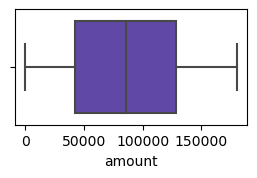

In [7]:
plt.figure(figsize=(3, 1.5))
sns.boxplot(data=globepay_acceptance_report_dataframe, x='amount')

In [8]:
outlier_analysis_helpers.detect_outliers_zscore(globepay_acceptance_report_dataframe, 'amount')

,external_ref,status,source,ref,date_time,state,cvv_provided,amount,country,currency,rates,zscore


From this initial outlier analysis, I am comfortable there are no large outliers that need to be removed from the dataset for the amount data.

#### Data Validation
At this stage I am adding some validation to ensure the data integrity for the data pipeline. I have done this by creating models of the two report types to ensure if these data comes through in the future, it will always be in this same format, to avoid any problems later on through the analysis pipeline.

In [9]:
validated_chargeback_df = globepay_mappers.map_chargeback_report(globepay_chargeback_report_dataframe)
validated_chargeback_df.head()

,external_ref,status,source,chargeback
0,_-UTDS0dMlagMWEtQKMy-,True,GLOBALPAY,False
1,_0fqf75KiPa0iiviKCSsU,True,GLOBALPAY,False
2,_0H9Ecd_RctsLetId-p14,True,GLOBALPAY,False
3,_0wBrMzAzIhO3fQRWUcBH,True,GLOBALPAY,False
4,_25jZuGDrmwUEdAwKp1xV,True,GLOBALPAY,False


In [10]:
validated_acceptance_df = globepay_mappers.map_acceptance_report(globepay_acceptance_report_dataframe)
validated_acceptance_df.head()

,external_ref,status,source,ref,date_time,state,cvv_provided,amount,country,currency,rates
0,nCyEIIGaP5QQ2Wqb-_Rt8,True,GLOBALPAY,evt_1ESgcCOV7fY1ChY1MkZizZt,2019-01-01 00:00:00,DECLINED,False,1020.46,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U..."
1,ptNiI9B7NNpK7VsMZx6zZ,True,GLOBALPAY,evt_1EBMGCEjEtianKMJaZXOx1y,2019-01-01 04:48:00,ACCEPTED,False,1582.57,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U..."
2,1GS5BDKBnauCt-3nHPs6x,True,GLOBALPAY,evt_1EOALu0AZqEhZBn9ub_nbcE,2019-01-01 09:36:00,DECLINED,False,1653.07,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U..."
3,Y_oecYz8GjBDaxmMqkkLQ,True,GLOBALPAY,evt_1ESHsWyaSPqE1mrmJ2B6rvs,2019-01-01 14:24:00,ACCEPTED,False,2228.17,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U..."
4,LlEs1TnKVa2xX6PH9Zsz0,True,GLOBALPAY,evt_1EjzPk13qLzmvDR_4hXuMMw,2019-01-01 19:12:00,ACCEPTED,False,2589.92,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U..."


In [11]:
cleaned_acceptance_report_length = len(validated_acceptance_df)
cleaned_chargeback_report_length = len(validated_chargeback_df)
print(f'Number of rows dropped post validation in acceptance report: \033[1m{original_acceptance_report_length-cleaned_acceptance_report_length}\033[0m')
print(f'Number of rows dropped post validation in chargeback report: \033[1m{original_chargeback_report_length-cleaned_chargeback_report_length}\033[0m')

Number of rows dropped post validation in acceptance report: 0
Number of rows dropped post validation in chargeback report: 0


### Combining the data frames on common data
Now both reports are cleaned and validated, I will combine them into one dataframe to maximise the amount of data easily available to analyse

In [12]:
globepay_df = pd.merge(
    validated_acceptance_df, 
    validated_chargeback_df, 
    on=['external_ref', 'status', 'source'], 
    how='inner'
)
globepay_df.head()

,external_ref,status,source,ref,date_time,state,cvv_provided,amount,country,currency,rates,chargeback
0,nCyEIIGaP5QQ2Wqb-_Rt8,True,GLOBALPAY,evt_1ESgcCOV7fY1ChY1MkZizZt,2019-01-01 00:00:00,DECLINED,False,1020.46,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U...",False
1,ptNiI9B7NNpK7VsMZx6zZ,True,GLOBALPAY,evt_1EBMGCEjEtianKMJaZXOx1y,2019-01-01 04:48:00,ACCEPTED,False,1582.57,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U...",True
2,1GS5BDKBnauCt-3nHPs6x,True,GLOBALPAY,evt_1EOALu0AZqEhZBn9ub_nbcE,2019-01-01 09:36:00,DECLINED,False,1653.07,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U...",False
3,Y_oecYz8GjBDaxmMqkkLQ,True,GLOBALPAY,evt_1ESHsWyaSPqE1mrmJ2B6rvs,2019-01-01 14:24:00,ACCEPTED,False,2228.17,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U...",True
4,LlEs1TnKVa2xX6PH9Zsz0,True,GLOBALPAY,evt_1EjzPk13qLzmvDR_4hXuMMw,2019-01-01 19:12:00,ACCEPTED,False,2589.92,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U...",True


## Task 1
Outline the volume in USD of the declined payments.

In [13]:
globepay_df.currency.unique()

array(['USD', 'MXN', 'GBP', 'EUR', 'CAD'], dtype=object)

In [14]:
len(globepay_df.rates.astype(str).unique())

1086

As I am dealing with more than one currency, I will perform a currency conversion to USD for all values. This is fairly simple as all rates are provided in reference to USD, and I have preserved the dictionary type of rates.

In [15]:
globepay_df['amount_usd'] = globepay_df.apply(lambda row: row['amount'] / row['rates'][row['currency']], axis=1)
globepay_df.head()

,external_ref,status,source,ref,date_time,state,cvv_provided,amount,country,currency,rates,chargeback,amount_usd
0,nCyEIIGaP5QQ2Wqb-_Rt8,True,GLOBALPAY,evt_1ESgcCOV7fY1ChY1MkZizZt,2019-01-01 00:00:00,DECLINED,False,1020.46,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U...",False,1020.46
1,ptNiI9B7NNpK7VsMZx6zZ,True,GLOBALPAY,evt_1EBMGCEjEtianKMJaZXOx1y,2019-01-01 04:48:00,ACCEPTED,False,1582.57,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U...",True,1582.57
2,1GS5BDKBnauCt-3nHPs6x,True,GLOBALPAY,evt_1EOALu0AZqEhZBn9ub_nbcE,2019-01-01 09:36:00,DECLINED,False,1653.07,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U...",False,1653.07
3,Y_oecYz8GjBDaxmMqkkLQ,True,GLOBALPAY,evt_1ESHsWyaSPqE1mrmJ2B6rvs,2019-01-01 14:24:00,ACCEPTED,False,2228.17,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U...",True,2228.17
4,LlEs1TnKVa2xX6PH9Zsz0,True,GLOBALPAY,evt_1EjzPk13qLzmvDR_4hXuMMw,2019-01-01 19:12:00,ACCEPTED,False,2589.92,US,USD,"{'CAD': 1.415, 'EUR': 0.926, 'MXN': 25.103, 'U...",True,2589.92


In [16]:
volume_of_declined_payments = globepay_df.loc[globepay_df['state']=='DECLINED']['amount_usd'].sum()
print(f'The volume of declined payments in USD is: \033[1m${volume_of_declined_payments:,.2f}\033[0m')

The volume of declined payments in USD is: $132,672,780.85


### Analysis of the reasons behind declined payments

#### Feature extraction
To have a better picture of what is going on in the dataset, we will extract some features that might be more insightful

Extracting the time of day as a feature

In [17]:
globepay_df['hour'] = globepay_df['date_time'].dt.hour
globepay_df['hour'].unique()

array([ 0,  4,  9, 14, 19])

Extracting other time parameters from date_time

In [18]:
globepay_df['week'] = globepay_df['date_time'].dt.isocalendar().week
globepay_df['day'] = globepay_df['date_time'].dt.dayofyear
globepay_df['month'] = globepay_df['date_time'].dt.month
globepay_df['year'] = globepay_df['date_time'].dt.year

In [19]:
print(globepay_df['year'].unique())
print(globepay_df['month'].unique())

[2019]
[1 2 3 4 5 6]


It appears the data only occurs over the 6 months from January - June 2019.

Extracting the unique rates as a feature

In [20]:
rates_df = pd.json_normalize(globepay_df['rates'])
globepay_df = pd.concat([globepay_df.drop(columns=['rates'], errors='ignore'), rates_df], axis=1)
globepay_df.head()

,external_ref,status,source,ref,date_time,state,cvv_provided,amount,country,currency,...,day,month,year,CAD,EUR,MXN,USD,SGD,AUD,GBP
0,nCyEIIGaP5QQ2Wqb-_Rt8,True,GLOBALPAY,evt_1ESgcCOV7fY1ChY1MkZizZt,2019-01-01 00:00:00,DECLINED,False,1020.46,US,USD,...,1,1,2019,1.415,0.926,25.103,1.0,1.434,1.648,0.813
1,ptNiI9B7NNpK7VsMZx6zZ,True,GLOBALPAY,evt_1EBMGCEjEtianKMJaZXOx1y,2019-01-01 04:48:00,ACCEPTED,False,1582.57,US,USD,...,1,1,2019,1.415,0.926,25.103,1.0,1.434,1.648,0.813
2,1GS5BDKBnauCt-3nHPs6x,True,GLOBALPAY,evt_1EOALu0AZqEhZBn9ub_nbcE,2019-01-01 09:36:00,DECLINED,False,1653.07,US,USD,...,1,1,2019,1.415,0.926,25.103,1.0,1.434,1.648,0.813
3,Y_oecYz8GjBDaxmMqkkLQ,True,GLOBALPAY,evt_1ESHsWyaSPqE1mrmJ2B6rvs,2019-01-01 14:24:00,ACCEPTED,False,2228.17,US,USD,...,1,1,2019,1.415,0.926,25.103,1.0,1.434,1.648,0.813
4,LlEs1TnKVa2xX6PH9Zsz0,True,GLOBALPAY,evt_1EjzPk13qLzmvDR_4hXuMMw,2019-01-01 19:12:00,ACCEPTED,False,2589.92,US,USD,...,1,1,2019,1.415,0.926,25.103,1.0,1.434,1.648,0.813


What about frequency of transactions?

In [21]:
globepay_df.groupby(['month']).size().reset_index(name='transaction_count').transaction_count.unique()

array([930, 840, 900])

In [22]:
globepay_df.groupby(['day']).size().reset_index(name='transaction_count').transaction_count.unique()

array([30])

While I thought this might be an interesting feature, the frequency in this dataset is consistent, so will not help us in the analysis.

Exploring the cumulative volume of the declined payments. Is it increasing?

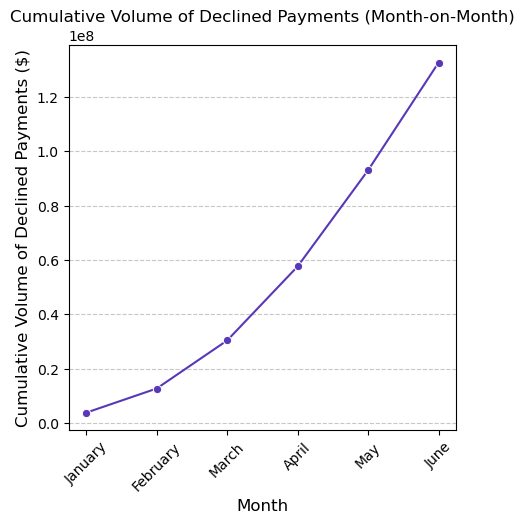

In [23]:
declined_payments = globepay_df[globepay_df['state'] == 'DECLINED']
monthly_declined_volume = declined_payments.groupby('month')['amount_usd'].sum().reset_index()
monthly_declined_volume['month'] = monthly_declined_volume['month'].apply(lambda x: calendar.month_name[x])
monthly_declined_volume['cumulative_volume'] = monthly_declined_volume['amount_usd'].cumsum()

plt.figure(figsize=(5, 5))
sns.lineplot(
    data=monthly_declined_volume,
    x='month',
    y='cumulative_volume',
    marker='o',
    )
plt.title('Cumulative Volume of Declined Payments (Month-on-Month)', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Cumulative Volume of Declined Payments ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The cumulative sum of declined payments appears to be accelerating, but is this indicating an increase in the rate of declined payments, or is the total number of payments through the platform simply increasing?

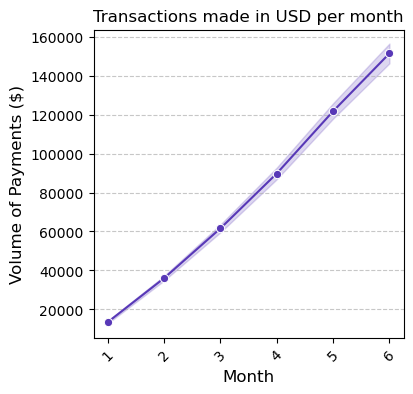

In [24]:
plt.figure(figsize=(4, 4))
sns.lineplot(
    data=globepay_df,
    x='month',
    y='amount_usd',
    marker='o'
    )
plt.title('Transactions made in USD per month', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Volume of Payments ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

From this, it appears the amount of payments going through the platform is increasing consistently, partly explaining the rapid increase in declined payments.

### Feature importance analysis
Having done some prelimary feature extraction, I am going to do some statistical analysis to get a better idea of root causes

#### Chi-squared analysis
Given the dataset is largely categorical, Chi-squared is a good place to start. This is a statistical test used to determine whether there is a significant associated between categorical variables. It compares the observed frequencies in a contingency table with the frequencies expected under the assumption of independence. It is measures by p-value, and a category that is seen to be statistically significant if p < 0.05, as this rejects the null hypothesis of independence.

In [25]:
chi2_results = feature_importance_analysis.calculate_chi2(globepay_df, 'state')
chi2_results.head()

,Variable,p_value
9,chargeback,5.912473e-24
12,week,1.269555e-01
14,month,1.588571e-01
8,currency,1.693141e-01
7,country,2.586465e-01


In [26]:
print("Significant Variables (p < 0.05):")
print(chi2_results[chi2_results['p_value'] < 0.05].values)

Significant Variables (p < 0.05):
[['chargeback' 5.912473219249344e-24]]


This chi-squared analysis I think is explainable (and therefore insignificant). It rightly shows that chargeback never happens for declined payments, so there is something significant there. However, if a payment is declined, and then charge will not be disputed hence no need for chargeback. So understanding of the data here is important!

<Axes: xlabel='state', ylabel='count'>

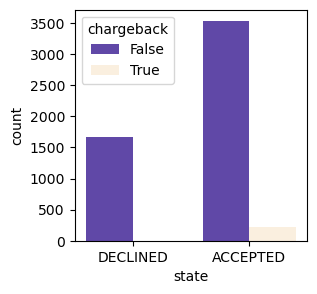

In [27]:
plt.figure(figsize=(3, 3))
sns.countplot(data=globepay_df, x='state', hue='chargeback')

#### Cramers V analysis
A standardised version of chi-squared analysis

In [28]:
feature_importance_analysis.calculate_cramers_v(globepay_df)

,column,cramers_v
0,external_ref,1.000000
1,amount_usd,1.000000
2,amount,1.000000
3,ref,1.000000
4,state,0.999568
5,AUD,0.435282
6,SGD,0.435282
7,MXN,0.435282
8,EUR,0.435282
9,GBP,0.435282


This analysis doesn't give any more informative data to the problem compared to chi-sqaured. There are misleading results in external_ref, amount_usd, amount and ref having high cramers_v. I am comfortable putting this down to the fact these are all unique values. It is essentially overfit, by showing that for example a particular ref is directly related to the state. So I will comfortably dismiss these, and then state shows up again in the same way.

We can apply a simple statistical machine learning model to the data and evaluate what coefficients it applies to the features. First, we need to convert the categorical variables to numerical using categorical encoding as the model expects numeric values.

For categorical columns that aren't boolean, or we don't want to preserve an order, we can apply one_hot_encoding. This stops bias being applied to the dataset.

In [29]:
one_hot_encoded_globepay_df = pd.get_dummies(globepay_df, columns=['country', 'currency'])
one_hot_encoded_globepay_df.head()

,external_ref,status,source,ref,date_time,state,cvv_provided,amount,chargeback,amount_usd,...,country_CA,country_FR,country_MX,country_UK,country_US,currency_CAD,currency_EUR,currency_GBP,currency_MXN,currency_USD
0,nCyEIIGaP5QQ2Wqb-_Rt8,True,GLOBALPAY,evt_1ESgcCOV7fY1ChY1MkZizZt,2019-01-01 00:00:00,DECLINED,False,1020.46,False,1020.46,...,0,0,0,0,1,0,0,0,0,1
1,ptNiI9B7NNpK7VsMZx6zZ,True,GLOBALPAY,evt_1EBMGCEjEtianKMJaZXOx1y,2019-01-01 04:48:00,ACCEPTED,False,1582.57,True,1582.57,...,0,0,0,0,1,0,0,0,0,1
2,1GS5BDKBnauCt-3nHPs6x,True,GLOBALPAY,evt_1EOALu0AZqEhZBn9ub_nbcE,2019-01-01 09:36:00,DECLINED,False,1653.07,False,1653.07,...,0,0,0,0,1,0,0,0,0,1
3,Y_oecYz8GjBDaxmMqkkLQ,True,GLOBALPAY,evt_1ESHsWyaSPqE1mrmJ2B6rvs,2019-01-01 14:24:00,ACCEPTED,False,2228.17,True,2228.17,...,0,0,0,0,1,0,0,0,0,1
4,LlEs1TnKVa2xX6PH9Zsz0,True,GLOBALPAY,evt_1EjzPk13qLzmvDR_4hXuMMw,2019-01-01 19:12:00,ACCEPTED,False,2589.92,True,2589.92,...,0,0,0,0,1,0,0,0,0,1


I am also going to drop columns that I know will not be relevant and will just add noise, i.e. external_ref and ref

In [30]:
one_hot_encoded_globepay_df.drop(columns=['external_ref', 'ref', 'date_time'], axis=1, inplace=True, errors='ignore')
one_hot_encoded_globepay_df.head()

,status,source,state,cvv_provided,amount,chargeback,amount_usd,hour,week,day,...,country_CA,country_FR,country_MX,country_UK,country_US,currency_CAD,currency_EUR,currency_GBP,currency_MXN,currency_USD
0,True,GLOBALPAY,DECLINED,False,1020.46,False,1020.46,0,1,1,...,0,0,0,0,1,0,0,0,0,1
1,True,GLOBALPAY,ACCEPTED,False,1582.57,True,1582.57,4,1,1,...,0,0,0,0,1,0,0,0,0,1
2,True,GLOBALPAY,DECLINED,False,1653.07,False,1653.07,9,1,1,...,0,0,0,0,1,0,0,0,0,1
3,True,GLOBALPAY,ACCEPTED,False,2228.17,True,2228.17,14,1,1,...,0,0,0,0,1,0,0,0,0,1
4,True,GLOBALPAY,ACCEPTED,False,2589.92,True,2589.92,19,1,1,...,0,0,0,0,1,0,0,0,0,1


I will also drop columns that have the same value across all rows

In [31]:
unique_one_hot_encoded_globepay_df = one_hot_encoded_globepay_df.loc[:, one_hot_encoded_globepay_df.nunique() > 1]
unique_one_hot_encoded_globepay_df.head()

,state,cvv_provided,amount,chargeback,amount_usd,hour,week,day,month,CAD,...,country_CA,country_FR,country_MX,country_UK,country_US,currency_CAD,currency_EUR,currency_GBP,currency_MXN,currency_USD
0,DECLINED,False,1020.46,False,1020.46,0,1,1,1,1.415,...,0,0,0,0,1,0,0,0,0,1
1,ACCEPTED,False,1582.57,True,1582.57,4,1,1,1,1.415,...,0,0,0,0,1,0,0,0,0,1
2,DECLINED,False,1653.07,False,1653.07,9,1,1,1,1.415,...,0,0,0,0,1,0,0,0,0,1
3,ACCEPTED,False,2228.17,True,2228.17,14,1,1,1,1.415,...,0,0,0,0,1,0,0,0,0,1
4,ACCEPTED,False,2589.92,True,2589.92,19,1,1,1,1.415,...,0,0,0,0,1,0,0,0,0,1


I want to apply categorical encoding to my binary values, to allow these to be interpreted by a statistical model

In [32]:
if unique_one_hot_encoded_globepay_df['state'].dtype != 'int64':
    unique_one_hot_encoded_globepay_df = unique_one_hot_encoded_globepay_df.copy()
    unique_one_hot_encoded_globepay_df['state'] = unique_one_hot_encoded_globepay_df['state'].map(
        {'ACCEPTED': 1, 'DECLINED': 0}
    )
if unique_one_hot_encoded_globepay_df['chargeback'].dtype != 'int64':
    unique_one_hot_encoded_globepay_df = unique_one_hot_encoded_globepay_df.copy()
    unique_one_hot_encoded_globepay_df['chargeback'] = unique_one_hot_encoded_globepay_df['chargeback'].map(
        {True: 1, False: 0}
    )
if unique_one_hot_encoded_globepay_df['cvv_provided'].dtype != 'int64':
    unique_one_hot_encoded_globepay_df = unique_one_hot_encoded_globepay_df.copy()
    unique_one_hot_encoded_globepay_df['cvv_provided'] = unique_one_hot_encoded_globepay_df['cvv_provided'].map(
        {True: 1, False: 0}
    )
unique_one_hot_encoded_globepay_df.head()

,state,cvv_provided,amount,chargeback,amount_usd,hour,week,day,month,CAD,...,country_CA,country_FR,country_MX,country_UK,country_US,currency_CAD,currency_EUR,currency_GBP,currency_MXN,currency_USD
0,0,0,1020.46,0,1020.46,0,1,1,1,1.415,...,0,0,0,0,1,0,0,0,0,1
1,1,0,1582.57,1,1582.57,4,1,1,1,1.415,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1653.07,0,1653.07,9,1,1,1,1.415,...,0,0,0,0,1,0,0,0,0,1
3,1,0,2228.17,1,2228.17,14,1,1,1,1.415,...,0,0,0,0,1,0,0,0,0,1
4,1,0,2589.92,1,2589.92,19,1,1,1,1.415,...,0,0,0,0,1,0,0,0,0,1


As I have lots of different features with different units, and I want to preserve the data distribution, I will now standardize the data set now it is numeric.

In [33]:
unique_one_hot_encoded_globepay_df = data_preparation_helpers.standardise_data(unique_one_hot_encoded_globepay_df)

### Logistic Regression analysis with L1 regularisation
For further feature importance analysis I want to apply more of a machine learning/statistical algorithm approach, which might have a better chance at detecting underlying trends than the solely statistical methods might do. Logistic regression is a really good starting point for looking at applying machine learning to a simple classification model, and can be really powerful for binary problems. For this analysis, I will be extracting what coefficients the trained model has determined for the dataset in an attempt to predict the outcome. Due to limited time, I want a snapshot high level feature importance analysis, so I am going to apply L1 or Lasso regularisation to the model. This approach will only return the top important features from the analysis, with less noise.

Training the Logistic Regression model with our data and target

In [34]:
target_variable = 'state'
data = unique_one_hot_encoded_globepay_df.drop(columns=['chargeback']).copy()
model = logistic_regression_analysis.LogisticRegressionModel(data=data, target_variable=target_variable)
model.train_test_split_data()
model.train_model()

Extracting the feature importance from the trained model

In [35]:
feature_importance = model.extract_feature_importance()
print("Feature Importance:")
print(feature_importance)

Feature Importance:
         feature  importance
16    country_MX    0.113732
6          month    0.058924
2     amount_usd    0.039641
15    country_FR    0.016184
3           hour    0.009097
5            day    0.006823
20  currency_EUR    0.001518
22  currency_MXN    0.000250
7            CAD    0.000000
21  currency_GBP    0.000000
17    country_UK    0.000000
13    country_AE    0.000000
4           week   -0.004452
11           AUD   -0.011447
23  currency_USD   -0.033948
12           GBP   -0.034080
9            MXN   -0.044104
19  currency_CAD   -0.047630
14    country_CA   -0.050435
8            EUR   -0.068350
10           SGD   -0.077217
18    country_US   -0.130600
0   cvv_provided   -0.246042
1         amount   -0.591643


Visualizing this result. We can see that the amount of the transaction has by fair the highest feature importance determined by the model, with cvv_provided a second.

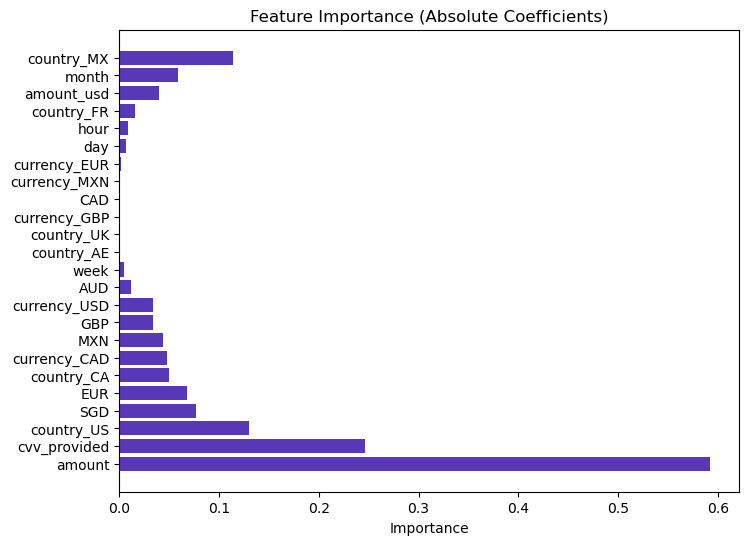

In [36]:
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['feature'], np.abs(feature_importance['importance']), color=deel_palette[True])
plt.xlabel('Importance')
plt.title('Feature Importance (Absolute Coefficients)')
plt.gca().invert_yaxis()
plt.show()

Visualising the top 5 features in relation to the target

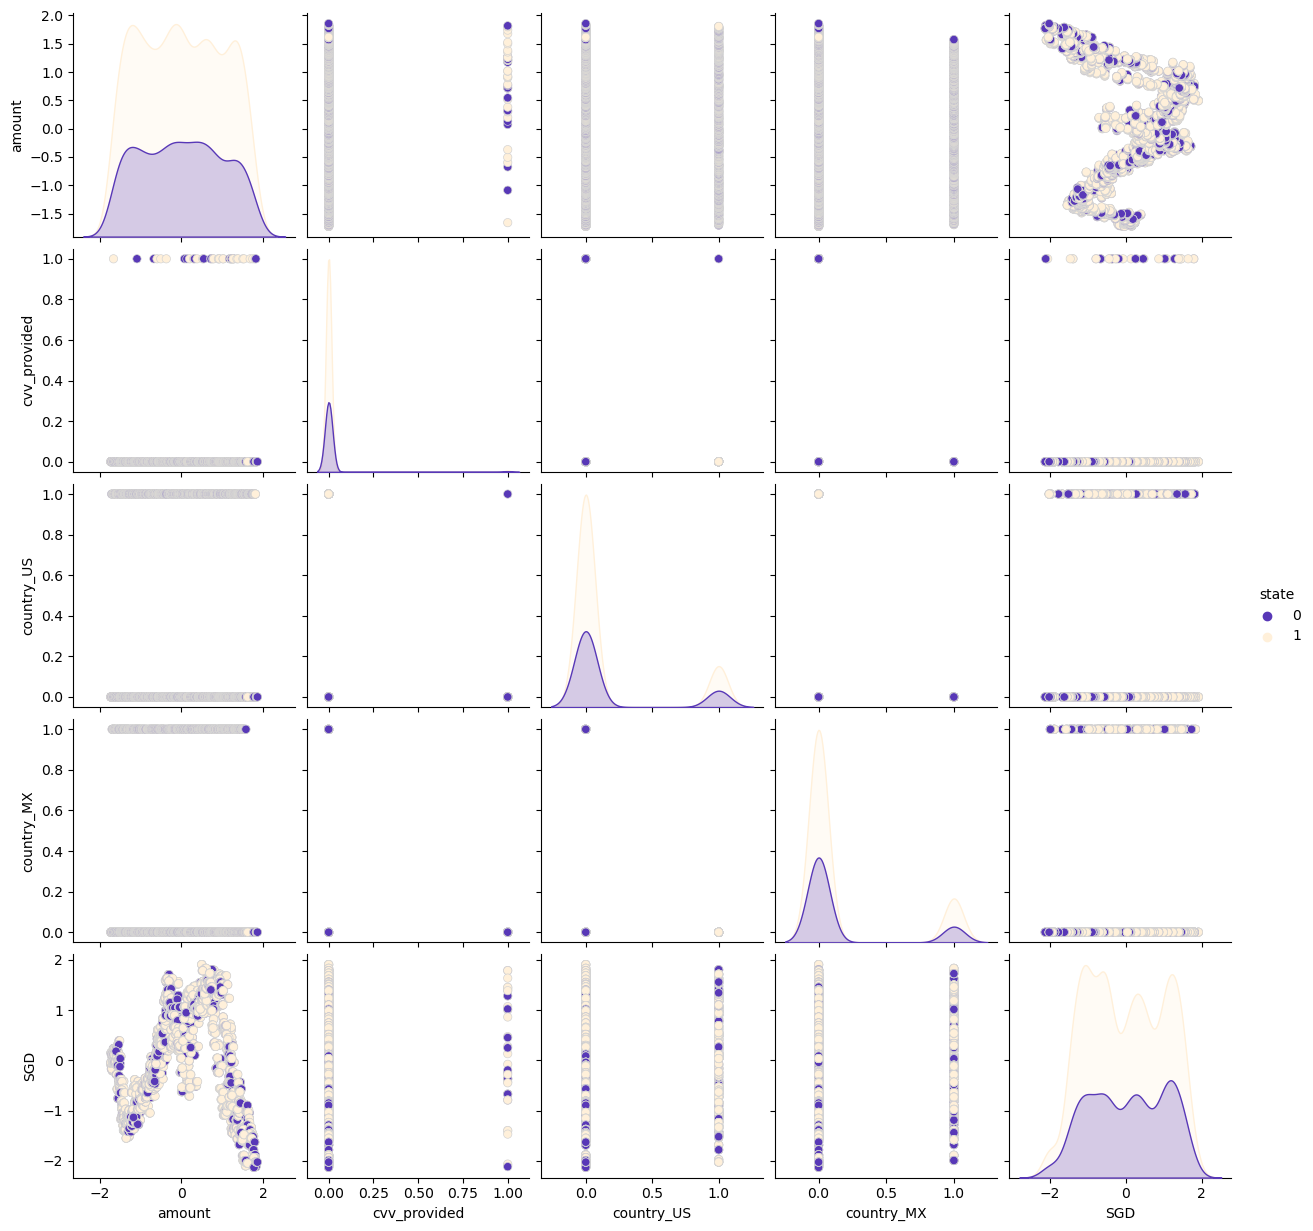

In [37]:
top_5_features = feature_importance.iloc[feature_importance['importance'].abs().argsort()[::-1]].head(5)['feature']
selected_features = np.append(top_5_features.values, 'state')
subset_df = unique_one_hot_encoded_globepay_df[selected_features]
sns.pairplot(
    subset_df,
    hue='state', 
    plot_kws={'edgecolor': 'lightgrey'}
)

The visualisation of the top 5 most important features in reference to the state does not show a clear relationship by eye. We should be careful to interpret the extracted feature importances too seriously.

I also want to evaluate the performance of the trained model on the data. This will help me determine my confidence in the feature importance analysis determined by the model. 

Model Accuracy: 0.69


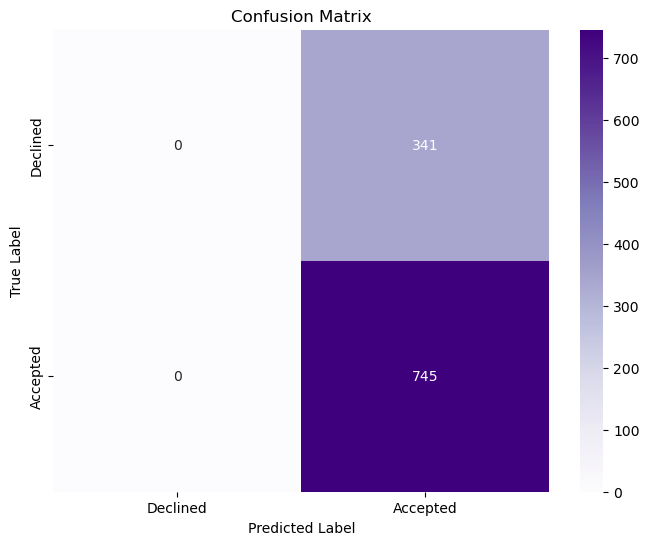

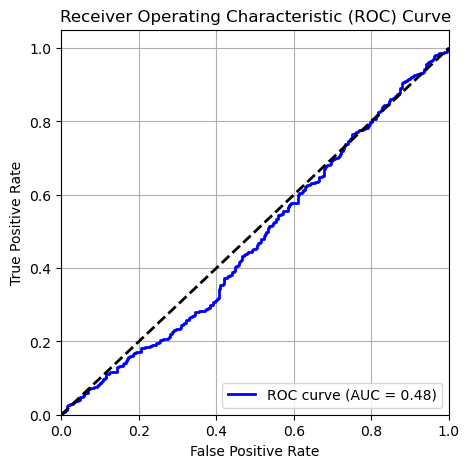

In [38]:
model.evaluate_model()

From evaluating the model, we can see the actual performance of the model is not generalisable to the test set at all. This suggests that the model has not done a good job at learning the underlying relationship on the data, or that the features in the dataset are not sufficient to predict the outcome.

However, the strength of the 'amount' feature and 'cvv_provided' feature indicate something significant in the underlying data. From this data alone, I would focus on this features to try and improve the acceptance rate. These two features could also be explained sensibly as well - the size of the number of the transaction may sensibly cause issues, and the extra layer of security with the cvv also makes sense to have an effect on how reliable the transactions are.

## Task 2
What is the acceptance rate over time?

Data occurs from January to June. Therefore I will segment the data into weeks and months

In [39]:
weekly_acceptance_ratio = acceptance_rate_analysis.get_acceptance_rate(globepay_df, ['week', 'country'])
monthly_acceptance_ratio = acceptance_rate_analysis.get_acceptance_rate(globepay_df, ['month', 'country'])

Text(0.5, 1.0, 'Weekly Acceptance Rate')

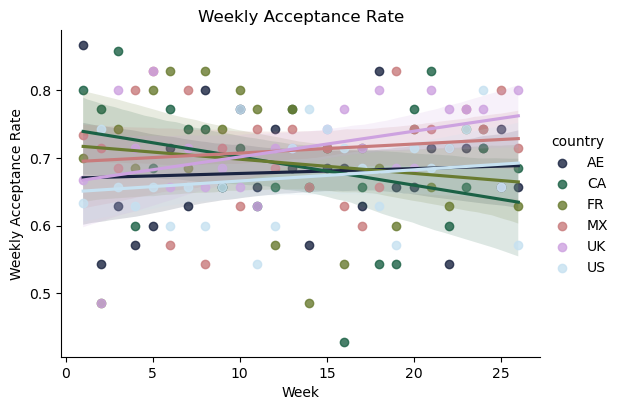

In [40]:
weekly_acceptance_ratio['week'] = weekly_acceptance_ratio['week'].astype(float)
g = sns.lmplot(
    data=weekly_acceptance_ratio, 
    x="week", 
    y="acceptance_ratio", 
    hue='country', 
    height=4, 
    aspect=1.4, 
    palette='cubehelix'
    )
plt.xlabel('Week')
plt.ylabel('Weekly Acceptance Rate')
plt.title('Weekly Acceptance Rate')

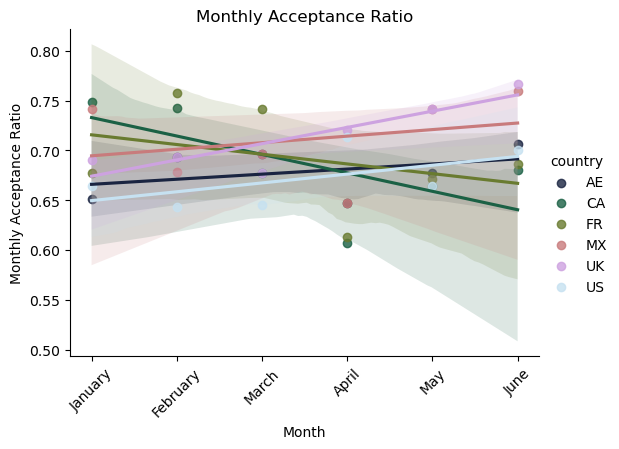

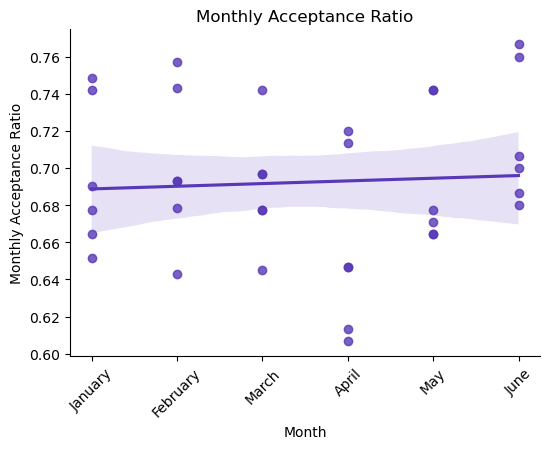

In [41]:
month_labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
available_months = monthly_acceptance_ratio['month'].unique() 
sns.lmplot(
    data=monthly_acceptance_ratio, 
    x='month', 
    y='acceptance_ratio', 
    hue='country', 
    height=4, 
    aspect=1.4, 
    palette='cubehelix'
)
plt.xticks(ticks=available_months, labels=[month_labels[i-1] for i in available_months], rotation=45)
plt.xlabel('Month')
plt.ylabel('Monthly Acceptance Ratio')
plt.title('Monthly Acceptance Ratio')
sns.lmplot(
    data=monthly_acceptance_ratio, 
    x='month', 
    y='acceptance_ratio', 
    height=4, 
    aspect=1.4, 
    palette='cubehelix'
)
plt.xticks(ticks=available_months, labels=[month_labels[i-1] for i in available_months], rotation=45)
plt.xlabel('Month')
plt.ylabel('Monthly Acceptance Ratio')
plt.title('Monthly Acceptance Ratio')

monthly_acceptance_ratio_filtered = monthly_acceptance_ratio[monthly_acceptance_ratio['month'].isin(available_months)]
plt.xticks(ticks=available_months, labels=[month_labels[i-1] for i in available_months], rotation=45);

From this analysis of the acceptance rate over time, we can see that the rate is fairly consistent over the 6 months. However, when splitting the data by the country the transction occurred, we can see clearer trends on the weekly and monthly data. While the rate is slowly increasing for many of the countries, for Canada and France, the acceptance rate is noticeable seen to decrease. This is worth further investigation into the reasons why.

List the countries where the amount of declined transactions went over $20M

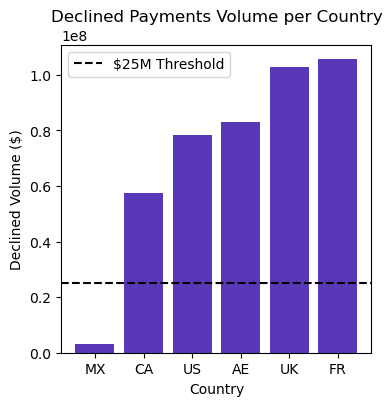

In [42]:
plt.figure(figsize=(4, 4))
country_declined_volume = globepay_df.groupby('country')['amount_usd'].sum().reset_index()
country_declined_volume.sort_values('amount_usd', ascending=True, inplace=True)
plt.bar(
    country_declined_volume.country,
    country_declined_volume.amount_usd,
    color=deel_palette[True]
)
plt.axhline(y=25000000, color='black', linestyle='--', label='$25M Threshold')
plt.xlabel("Country")
plt.ylabel("Declined Volume ($)")
plt.title("Declined Payments Volume per Country")
plt.legend()

In [43]:
countries = country_declined_volume.loc[country_declined_volume['amount_usd'] > 25000000, 'country'].values
country_mapping = {
    'US': 'United States',
    'MX': 'Mexico',
    'UK': 'United Kingdom',
    'FR': 'France',
    'CA': 'Canada',
    'AE': 'United Arab Emirates'
}
country_names = [country_mapping[country] for country in countries]
formatted_country_names = ', '.join(country_names)

print(f'The countries where the amount of declined transactions went over $25M are: \033[1m{formatted_country_names}\033[0m')

The countries where the amount of declined transactions went over $25M are: Canada, United States, United Arab Emirates, United Kingdom, France


Which transactions are missing chargeback data?

In [44]:
transactions_with_chargeback = globepay_df.loc[globepay_df['chargeback']==True]
transactions_without_chargeback = globepay_df.loc[globepay_df['chargeback']==False]
transactions_with_chargeback.describe()

,amount,amount_usd,hour,week,day,month,year,CAD,EUR,MXN,USD,SGD,AUD,GBP
count,223.000000,223.000000,223.000000,223.0,223.000000,223.0,223.0,223.000000,223.000000,223.000000,223.0,223.000000,223.000000,223.000000
mean,8011.763677,6556.797241,9.520179,1.735426,7.914798,1.0,2019.0,1.423365,0.907031,25.093027,1.0,1.428941,1.676422,0.830206
std,5487.780583,6141.811292,6.846338,0.792391,5.510588,0.0,0.0,0.014654,0.010753,0.007902,0.0,0.015135,0.014115,0.006167
min,-23.780000,-28.928552,0.000000,1.0,1.000000,1.0,2019.0,1.403038,0.883201,25.079567,1.0,1.391738,1.648000,0.813000
25%,3546.930000,1058.722384,4.000000,1.0,3.000000,1.0,2019.0,1.412819,0.900324,25.085965,1.0,1.419038,1.662346,0.826876
50%,7081.240000,4582.310000,9.000000,2.0,7.000000,1.0,2019.0,1.417266,0.909409,25.092979,1.0,1.435799,1.679789,0.830103
75%,12360.925000,10369.533184,14.000000,2.0,12.000000,1.0,2019.0,1.432214,0.913236,25.099563,1.0,1.440177,1.687680,0.834595
max,21485.420000,24319.245904,19.000000,3.0,20.000000,1.0,2019.0,1.457478,0.926000,25.108786,1.0,1.448957,1.702466,0.841873


In [45]:
transactions_without_chargeback.describe()

,amount,amount_usd,hour,week,day,month,year,CAD,EUR,MXN,USD,SGD,AUD,GBP
count,5207.000000,5207.000000,5207.000000,5207.0,5207.000000,5207.000000,5207.0,5207.000000,5207.000000,5207.000000,5207.0,5207.000000,5207.000000,5207.000000
mean,90318.802758,82352.476563,9.186288,14.075859,94.558287,3.615710,2019.0,1.398016,0.803190,25.082681,1.0,1.437195,1.626051,0.747189
std,48598.745868,66047.166327,6.792848,7.197705,50.376661,1.663952,0.0,0.023226,0.075482,0.023556,0.0,0.031507,0.035501,0.063138
min,42.190000,50.953515,0.000000,1.0,1.000000,1.000000,2019.0,1.346586,0.668442,25.035636,1.0,1.370696,1.566294,0.653249
25%,48332.230000,23709.135183,4.000000,8.0,51.000000,2.000000,2019.0,1.380524,0.729271,25.063679,1.0,1.408898,1.600773,0.689862
50%,89146.700000,73781.250000,9.000000,14.0,95.000000,4.000000,2019.0,1.396946,0.824026,25.081129,1.0,1.438266,1.614682,0.731058
75%,130920.070000,125677.665378,14.000000,20.0,138.000000,5.000000,2019.0,1.411296,0.871371,25.099366,1.0,1.467683,1.637188,0.796414
max,180371.520000,254082.777493,19.000000,26.0,181.000000,6.000000,2019.0,1.459481,0.926000,25.144172,1.0,1.496032,1.713387,0.869061


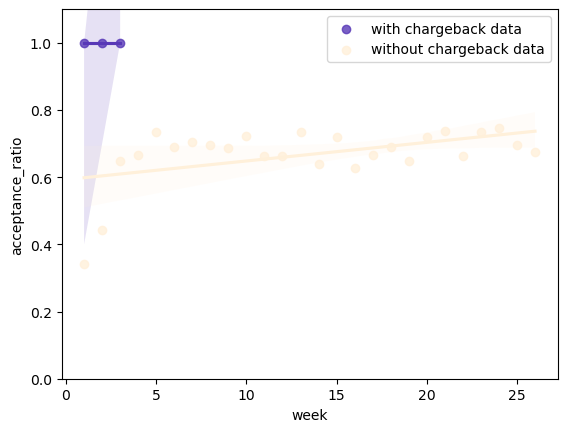

In [46]:
weekly_acceptance_ratio_with_chargeback = acceptance_rate_analysis.get_acceptance_rate(transactions_with_chargeback, ['week'])
weekly_acceptance_ratio_without_chargeback = acceptance_rate_analysis.get_acceptance_rate(transactions_without_chargeback, ['week'])

weekly_acceptance_ratio_with_chargeback['week'] = weekly_acceptance_ratio_with_chargeback['week'].astype(float)
weekly_acceptance_ratio_without_chargeback['week'] = weekly_acceptance_ratio_without_chargeback['week'].astype(float)

ax = sns.regplot(data=weekly_acceptance_ratio_with_chargeback, x="week", y="acceptance_ratio", label='with chargeback data')
h = sns.regplot(data=weekly_acceptance_ratio_without_chargeback, x="week", y="acceptance_ratio", ax=ax, label='without chargeback data')
ax.set_ylim(0, 1.1)

plt.legend()

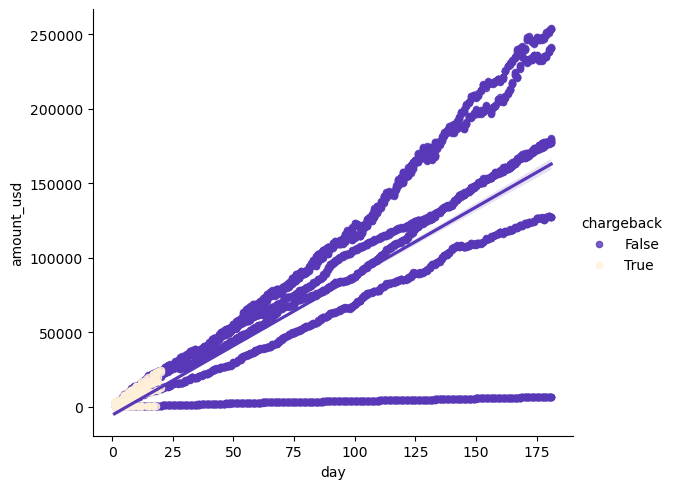

In [47]:
globepay_df['day'] = globepay_df['day'].astype(float)

sns.lmplot(
    data=globepay_df, 
    x="day", 
    y="amount_usd", 
    hue="chargeback", 
    logistic=False, 
    aspect=1.2,
    scatter_kws={'s': 20}
)

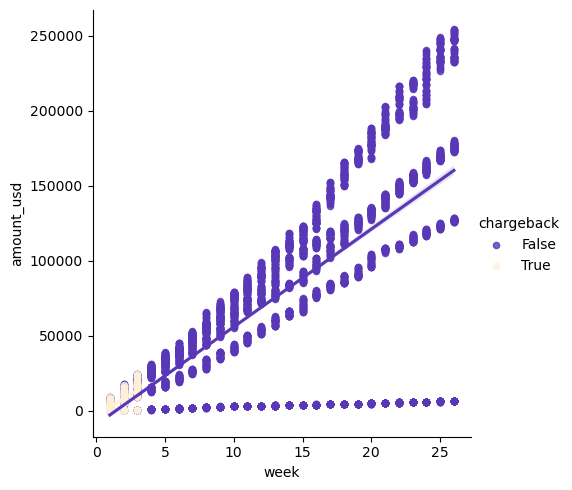

In [48]:
globepay_df['week'] = globepay_df['week'].astype(float)

sns.lmplot(
    data=globepay_df, 
    x="week", 
    y="amount_usd", 
    hue="chargeback", 
    logistic=False, 
    scatter_kws={'s': 20}
)

It appears that the transactions that don't have chargeback data are transactions that occur after an initial regular transaction has been set up. The transactions that do have chargeback data are a proportion of the intial transactions for the set up payments in their first 3 weeks of the year. It makes sense that upon set up, disbutes are more likely. Once the payment is regular, chargeback will stop. Therefore chargeback is something that should be expected in the initialisation of a new regular payment.